# Getting satellite cloud data for CTIO

## Notebook setup

In [1]:
from astropy.coordinates import EarthLocation
import json
from urllib.request import urlopen
from urllib.request import urlretrieve
import urllib.parse
import os
import re
import glob
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import numpy as np
from astropy.time import Time

The search page is here: https://inventory.ssec.wisc.edu/inventory/#search

Band descriptions: http://cimss.ssec.wisc.edu/goes/webapps/bandapp/GOES_Imager_Spectral_Bands_overview.pdf

The satelite that covers CTIO is GOES-13 before 2018-12-18, and GOES-16 after.

In [2]:
ctio = EarthLocation.of_site('CTIO')
ctio.lat.deg, ctio.lon.deg

(-30.165277777777778, -70.815)

The SDS access key is obtained by registering with the SDS site.

In [3]:
with open('/sdf/data/rubin/u/neilsen/McFETCH_access_key') as key_io:
    sds_key = key_io.read()

# Using University of Wisconsin-Madison Space Science and Engineering Center's Satelite Data Service

Query URL looks like this: https://inventory.ssec.wisc.edu/inventory/assets/python/query.py?start_time=2015-08-15%2000%3A00%3A00&end_time=2015-08-15%2023%3A59%3A00&satellite=GOES-13&advanced_lat=-30&advanced_lon=70.2&output=json

In [4]:
urllib.parse.unquote('2015-08-15%2000%3A00%3A00')

'2015-08-15 00:00:00'

Code to query the SDS inventory for a time range. If possible, load the result from a cacheg (unless `force_query=True`), and save the result in a cache.

In [5]:
def read_sds_inventory(start_time, end_time, inventory_fname='sds_inventories.h5', force_query=False):
    lat = int(np.round(ctio.lat.deg))
    
    # SDS uses degrees west, not east
    lon = int(np.round(-1 * ctio.lon.deg))
    
    satellite = 'GOES-13'
    start_time = urllib.parse.quote(start_time)
    end_time = urllib.parse.quote(end_time)
    
    inventory_url = f'https://inventory.ssec.wisc.edu/inventory/assets/python/query.py?start_time={start_time}&end_time={end_time}&satellite={satellite}&advanced_lat={lat}&advanced_lon={lon}&output=csv'
    key = re.sub(r'['+re.escape(':/?=.- &%')+']', '_', inventory_url)
    do_query = force_query or (inventory_fname is None)

    if not do_query:
        try:
            sds_inventory = pd.read_hdf(inventory_fname, key)
        except (FileNotFoundError, KeyError):
            do_query = True

    if do_query:
        with urlopen(inventory_url) as sds_io:
            sds_inventory = pd.read_csv(sds_io)
            if inventory_fname is not None:
                sds_inventory.to_hdf(inventory_fname, key)
        
    return sds_inventory

In [6]:
sds_inventory = read_sds_inventory('2015-08-15 00:00:00', '2015-08-15 23:59:00')
sds_inventory.head()

,imagetime,bandmap,w_elem,e_elem,n_line,s_line,sub_lat,sub_lon,filename,tapename,tapepos,source,md5data,md5index,tstamp,coverage,type,schedule
0,2015-08-15 00:37:34,"1-4,6",9061,22912,10077,12344,0.02,74.94,goes13.2015.227.003734.INDX,None,None,sdilambda,02333d1a3ef1dbb13efccc2677990e1d,4fa77d2f862cb001fcdd24e79b5c6c1f,2015-08-15 00:46:41,SH,Imager,ROUTINE
1,2015-08-15 01:07:34,"1-4,6",9061,22912,10077,12344,0.02,74.94,goes13.2015.227.010734.INDX,None,None,sdieta,48ea2be28e9a12ade295db090efc14a9,c831d167f0472d4ecb1a3d30cb8cac41,2015-08-15 01:16:43,SH,Imager,ROUTINE
2,2015-08-15 01:37:33,"1-4,6",9061,22912,10077,12344,0.02,74.95,goes13.2015.227.013733.INDX,None,None,sdilambda,99c9cf807fcf55d745e49b7c5cd2a0c1,4d3fe2ac25f566e8419dafc01e9c21fa,2015-08-15 01:47:13,SH,Imager,ROUTINE
3,2015-08-15 02:07:34,"1-4,6",9061,22912,10077,12344,0.03,74.95,goes13.2015.227.020734.INDX,None,None,sdieta,5220f90ade5da0e5185a35568cb6acb5,c9379709c72afb001ecda30cd3f41dd7,2015-08-15 02:16:50,SH,Imager,ROUTINE
4,2015-08-15 02:37:33,"1-4,6",9061,22912,10077,12344,0.03,74.96,goes13.2015.227.023733.INDX,None,None,sdilambda,9d7cafc2a6c6373fb8d9e3422118a6f0,f584d5807da6e1a529692ea165edbc21,2015-08-15 02:46:34,SH,Imager,ROUTINE


In [7]:
def get_satellite_data(tstamp, band, directory='data'):
    key = sds_key
    satellite = 'GOES13'
    lat = int(np.round(ctio.lat.deg))
    lon = int(np.round(-1 * ctio.lon.deg))
    latlon = f'{lat}+{lon}' if lon > 0 else f'{lat}{lon}'
    # size = '480+640'
    size = '256+256'
    im_date, im_time = tstamp.split()
    im_date = im_date.replace('-', '')
    coverage = 'SH'
    url = f'https://mcfetch.ssec.wisc.edu/cgi-bin/mcfetch?dkey={key}&satellite={satellite}&output=NETCDF&lat={latlon}&size={size}&date={im_date}&time={im_time}&coverage={coverage}&band={band}'
    fname_tstring = tstamp.replace(' ', 'T').replace(':', '')
    fname = f'{directory}/{satellite}_{band}_{fname_tstring}.nc'
    if not os.path.exists(fname):
        urlretrieve(url, fname)
    return fname

In [8]:
fname = get_satellite_data(sds_inventory.loc[0, 'tstamp'], 4)

In [9]:
data = scipy.io.netcdf_file(fname, 'r', mmap=False)

In [10]:
data.variables

{'version': <scipy.io._netcdf.netcdf_variable at 0x7f64a4b5d9f0>,
 'sensorID': <scipy.io._netcdf.netcdf_variable at 0x7f64a4b5f1f0>,
 'imageDate': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c2ef0>,
 'imageTime': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c2ec0>,
 'startLine': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c28f0>,
 'startElem': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c2350>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c2e60>,
 'dataWidth': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c2e30>,
 'lineRes': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c3850>,
 'elemRes': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c30d0>,
 'prefixSize': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c3df0>,
 'crDate': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c3760>,
 'crTime': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c3e50>,
 'bands': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c3b20>,
 'auditTrail': <scipy.io._netcdf.netcdf_variable at 0x7f64a43c30a0>,


In [11]:
data.dimensions

{'xc': 256, 'yc': 256, 'time': 1, 'auditCount': 3, 'auditSize': 80}

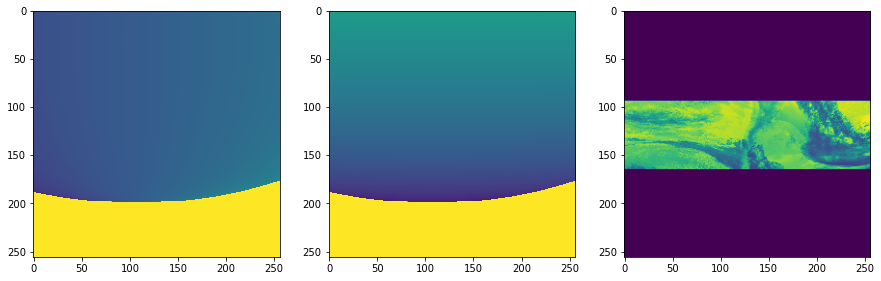

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].imshow(data.variables['lon'].data[:,:], vmin=-180, vmax=180)
axes[1].imshow(data.variables['lat'].data[:,:], vmin=-90, vmax=90)
axes[2].imshow(data.variables['data'].data[0,:,:])

In [13]:
data.variables['lat'].data[64, 64], data.variables['lon'].data[64, 64]

(-9.738185, -82.147385)

Great, it looks like our requested coordinates are at the center (or close enough).

# Getting data for missing times

In [14]:
wide_night_events = pd.read_hdf('night_events.h5')
report_clouds = pd.read_hdf('clouds_ctio_blanco.h5').reset_index().set_index(['year', 'month', 'sday', 'quarter'])

In [15]:
wide_night_events.head()

night         start        middle           end  \
year month sday                                                    
1975 1     1     42413  42414.041954  42414.199084  42414.356215   
           2     42414  42415.042040  42415.199412  42415.356783   
           3     42415  42416.042102  42416.199735  42416.357368   
           4     42416  42417.042140  42417.200054  42417.357967   
           5     42417  42418.042155  42418.200368  42418.358581   

                 night_duration  quarter_duration        q1_mjd        q2_mjd  \
year month sday                                                                 
1975 1     1           0.314261          0.078565  42414.081236  42414.159802   
           2           0.314744          0.078686  42415.081383  42415.160069   
           3           0.315266          0.078816  42416.081510  42416.160327   
           4           0.315827          0.078957  42417.081619  42417.160575   
           5           0.316426          0.079107  42418.081708  42418.160815   

                       q3_mjd        q4_mjd  end_offset  start_offset  \
year month sday                                                         
1975 1     1     42414.238367  42414.316932    1.356215      1.041954   
           2     42415.238754  42415.317440    1.356783      1.042040   
           3     42416.239143  42416.317959    1.357368      1.042102   
           4     42417.239532  42417.318489    1.357967      1.042140   
           5     42418.239921  42418.319028    1.358581      1.042155   

                 q1_offset  q2_offset  q3_offset  q4_offset  
year month sday                                              
1975 1     1      1.081236   1.159802   1.238367   1.316932  
           2      1.081383   1.160069   1.238754   1.317440  
           3      1.081510   1.160327   1.239143   1.317959  
           4      1.081619   1.160575   1.239532   1.318489  
           5      1.081708   1.160815   1.239921   1.319028

In [16]:
report_clouds.head()

index       date  eday  clouds source
year month sday quarter                                       
1975 1     1    1            0 1975-01-01     2       0   ctio
                2            1 1975-01-01     2       0   ctio
                3            2 1975-01-01     2       0   ctio
                4            3 1975-01-01     2       0   ctio
           2    1            4 1975-01-02     3       0   ctio

In [17]:
night_events = pd.wide_to_long(
    wide_night_events.rename(columns={'q1_mjd': 'q1', 'q2_mjd': 'q2', 'q3_mjd': 'q3', 'q4_mjd': 'q4'})[['night', 'quarter_duration', 'q1', 'q2', 'q3', 'q4']].reset_index(),
    stubnames=['q'],
    i=['year', 'month', 'sday'],
    j='quarter'
).rename(columns={'q': 'center_mjd'})
night_events['start_mjd'] = night_events['center_mjd'] - night_events['quarter_duration']/2
night_events['end_mjd'] = night_events['center_mjd'] + night_events['quarter_duration']/2
night_events.reset_index(inplace=True)
night_events.set_index(['year', 'month', 'sday', 'quarter'], inplace=True)
night_events

night  quarter_duration    center_mjd     start_mjd  \
year month sday quarter                                                        
1975 1     1    1        42413          0.078565  42414.081236  42414.041954   
                2        42413          0.078565  42414.159802  42414.120519   
                3        42413          0.078565  42414.238367  42414.199084   
                4        42413          0.078565  42414.316932  42414.277650   
           2    1        42414          0.078686  42415.081383  42415.042040   
...                        ...               ...           ...           ...   
2022 9     3    4        59825          0.108249  59826.358150  59826.304026   
           4    1        59826          0.107957  59827.033610  59826.979631   
                2        59826          0.107957  59827.141566  59827.087588   
                3        59826          0.107957  59827.249523  59827.195545   
                4        59826          0.107957  59827.357479  59827.303501   

                              end_mjd  
year month sday quarter                
1975 1     1    1        42414.120519  
                2        42414.199084  
                3        42414.277650  
                4        42414.356215  
           2    1        42415.120726  
...                               ...  
2022 9     3    4        59826.412275  
           4    1        59827.087588  
                2        59827.195545  
                3        59827.303501  
                4        59827.411458  

[69652 rows x 5 columns]

In [18]:
def to_iso(mjd):
    t = Time(mjd, format='mjd', scale='utc')
    return t.iso[:19]

In [19]:
report_clouds['start_iso'] = night_events['start_mjd'].apply(to_iso)
report_clouds['end_iso'] = night_events['end_mjd'].apply(to_iso)
report_clouds

index       date  eday  clouds  source  \
year month sday quarter                                           
1975 1     1    1            0 1975-01-01     2       0    ctio   
                2            1 1975-01-01     2       0    ctio   
                3            2 1975-01-01     2       0    ctio   
                4            3 1975-01-01     2       0    ctio   
           2    1            4 1975-01-02     3       0    ctio   
...                        ...        ...   ...     ...     ...   
2022 9     3    4        69647 2022-09-03     4       0  blanco   
           4    1        69648 2022-09-04     5       0  blanco   
                2        69649 2022-09-04     5       0  blanco   
                3        69650 2022-09-04     5       0  blanco   
                4        69651 2022-09-04     5       0  blanco   

                                   start_iso              end_iso  
year month sday quarter                                            
1975 1     1    1        1975-01-02 01:00:24  1975-01-02 02:53:32  
                2        1975-01-02 02:53:32  1975-01-02 04:46:40  
                3        1975-01-02 04:46:40  1975-01-02 06:39:48  
                4        1975-01-02 06:39:48  1975-01-02 08:32:56  
           2    1        1975-01-03 01:00:32  1975-01-03 02:53:50  
...                                      ...                  ...  
2022 9     3    4        2022-09-04 07:17:47  2022-09-04 09:53:40  
           4    1        2022-09-04 23:30:40  2022-09-05 02:06:07  
                2        2022-09-05 02:06:07  2022-09-05 04:41:35  
                3        2022-09-05 04:41:35  2022-09-05 07:17:02  
                4        2022-09-05 07:17:02  2022-09-05 09:52:29  

[69652 rows x 7 columns]

## Get data for a sample clear time

In [20]:
start_time, end_time = report_clouds.loc[(2015, 12, 30, 2), ['start_iso', 'end_iso']]
start_time, end_time

('2015-12-31 02:52:49', '2015-12-31 04:45:40')

In [21]:
def get_quarter(tstring, quarter, band=4, report_clouds=report_clouds):
    t = Time(tstring)
    dirname = f"data/satellite_{t.datetime.year}-{t.datetime.month:02d}-{t.datetime.day:02d}_q{quarter}"
    try:
        os.mkdir(dirname)
    except FileExistsError:
        pass
    start_iso, end_iso = report_clouds.loc[(t.datetime.year, t.datetime.month, t.datetime.day, quarter), ['start_iso', 'end_iso']]
    this_inventory = read_sds_inventory(start_iso, end_iso)
    this_inventory['dirname'] = dirname
    this_inventory['year'] = t.datetime.year
    this_inventory['month'] = t.datetime.month
    this_inventory['sday'] = t.datetime.day
    this_inventory['quarter'] = quarter

    sds_inventory = read_sds_inventory(start_iso, end_iso).query('coverage == "SH"')
    
    fnames = []
    print("Downloading", end="")
    for idx, record in sds_inventory.iterrows():
        print(f" {idx}", end="")
        fname = get_satellite_data(record.tstamp, band, directory=dirname)
        fnames.append(fname)
    print("")
        
    return fnames

clear_fnames = get_quarter('2015-12-30', 1)

## Get missing late 2015 quarters

In [22]:
missing_quarters = report_clouds.query('(clouds==9) and (year==2015) and (12>month>=7)')

In [23]:
sds_inventories = []
for id, quarter in list(missing_quarters.reset_index().iterrows()):
    dirname = f"satellite_{quarter.year}-{quarter.month:02d}-{quarter.sday:02d}_q{quarter.quarter}"
    this_inventory = read_sds_inventory(quarter.start_iso, quarter.end_iso)
    this_inventory['dirname'] = dirname
    this_inventory['year'] = quarter.year
    this_inventory['month'] = quarter.month
    this_inventory['sday'] = quarter.sday
    this_inventory['quarter'] = quarter.quarter
    sds_inventories.append(this_inventory)
    
sds_inventory = pd.concat(sds_inventories).set_index(['year', 'month', 'sday', 'quarter'])
sds_inventory

imagetime bandmap  w_elem  e_elem  n_line  \
year month sday quarter                                                        
2015 7     1    1        2015-07-01 23:07:33   1-4,6    9061   22912   10077   
                1        2015-07-01 23:37:34   1-4,6    9061   22912   10077   
                1        2015-07-01 23:45:18   1-4,6    5861   26684    2621   
                1        2015-07-02 00:37:34   1-4,6    9061   22912   10077   
                1        2015-07-02 01:07:34   1-4,6    9061   22912   10077   
...                                      ...     ...     ...     ...     ...   
     11    11   3        2015-11-12 05:45:18   1-4,6    4009   24840    2621   
                4        2015-11-12 06:37:33   1-4,6    9061   22912   10077   
                4        2015-11-12 07:07:33   1-4,6    9061   22912   10077   
                4        2015-11-12 07:37:32   1-4,6    9061   22912   10077   
                4        2015-11-12 08:07:33   1-4,6    9061   22912   10077   

                         s_line  sub_lat  sub_lon  \
year month sday quarter                             
2015 7     1    1         12344    -0.14    74.70   
                1         12344    -0.13    74.70   
                1         13440    -0.13    74.70   
                1         12344    -0.12    74.71   
                1         12344    -0.11    74.71   
...                         ...      ...      ...   
     11    11   3         13440    -0.08    74.82   
                4         12344    -0.06    74.82   
                4         12344    -0.04    74.82   
                4         12344    -0.03    74.81   
                4         12344    -0.01    74.81   

                                            filename tapename tapepos  \
year month sday quarter                                                 
2015 7     1    1        goes13.2015.182.230733.INDX     None    None   
                1        goes13.2015.182.233734.INDX     None    None   
                1        goes13.2015.182.234518.INDX     None    None   
                1        goes13.2015.183.003734.INDX     None    None   
                1        goes13.2015.183.010734.INDX     None    None   
...                                              ...      ...     ...   
     11    11   3        goes13.2015.316.054518.INDX     None    None   
                4        goes13.2015.316.063733.INDX     None    None   
                4        goes13.2015.316.070733.INDX     None    None   
                4        goes13.2015.316.073732.INDX     None    None   
                4        goes13.2015.316.080733.INDX     None    None   

                            source                           md5data  \
year month sday quarter                                                
2015 7     1    1           sdieta  35a1e6b9a1834578f5ba7801fa43aa23   
                1           sdieta  7a6738f8c102eb8bb9f93df9bd340191   
                1           sdieta  25014e22f79f40bddcd582069688d582   
                1        sdilambda  8486cb40390956416f4f3e06d3b67d7f   
                1           sdieta  4649b423208bca4e2a676a97537f8495   
...                            ...                               ...   
     11    11   3           sdieta  a458a7846bee139df66e1331668d3b3d   
                4        sdilambda  da45baa5f1fb52094eb599dd41d459b1   
                4        sdilambda  3a48c86b6b1783f2017e8e5480c8ed0d   
                4        sdilambda  11e73e935e9dff145bc5012f12d2d676   
                4            sdimu  299076b187cfe7f57ae96951e264ce4b   

                                                 md5index  \
year month sday quarter                                     
2015 7     1    1        87fa3ddfe88c3ea2773cc2d99f2f0755   
                1        700cc7bdb7016c413f23649982197fcf   
                1        0f11ad2ba8aa70415a748483d01e02a9   
                1        507fe9452bd3f408bcd0a7b772f09e15   
                1        609f9c02ecda5fec5a742776c1

In [24]:
sds_inventory.to_hdf('aug2015_inventory.h5', 'missing')

In [25]:
qs_to_get = sds_inventory.query('coverage=="SH"').groupby(['year', 'month', 'sday', 'quarter']).count()
qs_to_get

imagetime  bandmap  w_elem  e_elem  n_line  s_line  \
year month sday quarter                                                       
2015 7     1    1                5        5       5       5       5       5   
                2                5        5       5       5       5       5   
                3                5        5       5       5       5       5   
                4                4        4       4       4       4       4   
           3    2                4        4       4       4       4       4   
...                            ...      ...     ...     ...     ...     ...   
     8     27   3                4        4       4       4       4       4   
     11    5    4                5        5       5       5       5       5   
           11   2                2        2       2       2       2       2   
                3                3        3       3       3       3       3   
                4                4        4       4       4       4       4   

                         sub_lat  sub_lon  filename  tapename  tapepos  \
year month sday quarter                                                  
2015 7     1    1              5        5         5         5        5   
                2              5        5         5         5        5   
                3              5        5         5         5        5   
                4              4        4         4         4        4   
           3    2              4        4         4         4        4   
...                          ...      ...       ...       ...      ...   
     8     27   3              4        4         4         4        4   
     11    5    4              5        5         5         5        5   
           11   2              2        2         2         2        2   
                3              3        3         3         3        3   
                4              4        4         4         4        4   

                         source  md5data  md5index  tstamp  coverage  type  \
year month sday quarter                                                      
2015 7     1    1             5        5         5       5         5     5   
                2             5        5         5       5         5     5   
                3             5        5         5       5         5     5   
                4             4        4         4       4         4     4   
           3    2             4        4         4       4         4     4   
...                         ...      ...       ...     ...       ...   ...   
     8     27   3             4        4         4       4         4     4   
     11    5    4             5        5         5       5         5     5   
           11   2             2        2         2       2         2     2   
                3             3        3         3       3         3     3   
                4             4        4         4       4         4     4   

                         schedule  dirname  
year month sday quarter                     
2015 7     1    1               5        5  
                2               5        5  
                3               5        5  
                4               4        4  
           3    2               4        4  
...                           ...      ...  
     8     27   3               4        4  
     11    5    4               5        5  
           11   2               2        2  
                3               3        3  
                4               4        4  

[79 rows x 19 columns]

In [26]:
missing_fnames = {}
for idx, quarter in qs_to_get.iterrows():
    year, month, day, quarter = idx
    iso_date = f'{year}-{month:02d}-{day:02d}'
    key = f"{iso_date}_{quarter}"
    missing_fnames[key] = get_quarter(iso_date, quarter)

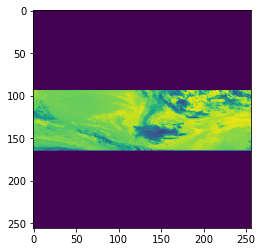

In [27]:
fig = plt.figure()
frames = []
for key in missing_fnames.keys():
    for fname in missing_fnames[key]:
        data = scipy.io.netcdf_file(fname, 'r', mmap=False)
        frames.append([plt.imshow(data.variables['data'].data[0,:,:])])

clear_animation = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
display(HTML(clear_animation.to_html5_video()))


In [28]:
missing_values = []
for key in missing_fnames.keys():
    for fname in missing_fnames[key]:
        data = scipy.io.netcdf_file(fname, 'r', mmap=False)
        missing_values.append(data.variables['data'].data[0,128,128])

(array([11., 26., 24., 32., 18., 14., 37., 69., 90., 19.]),
 array([ 5024. ,  6044.8,  7065.6,  8086.4,  9107.2, 10128. , 11148.8,
        12169.6, 13190.4, 14211.2, 15232. ], dtype=float32),
 <BarContainer object of 10 artists>)

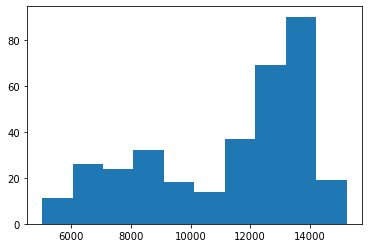

In [29]:
plt.hist(missing_values)

Get values for missing quarters in band 6

In [30]:
missing_fnames_band6 = {}
for idx, quarter in qs_to_get.iterrows():
    year, month, day, quarter = idx
    iso_date = f'{year}-{month:02d}-{day:02d}'
    key = f"{iso_date}_{quarter}"
    missing_fnames_band6[key] = get_quarter(iso_date, quarter, band=6)

In [31]:
missing_fnames_band6.keys()

dict_keys(['2015-07-01_1', '2015-07-01_2', '2015-07-01_3', '2015-07-01_4', '2015-07-03_2', '2015-07-03_3', '2015-07-03_4', '2015-07-04_1', '2015-07-04_2', '2015-07-04_3', '2015-07-04_4', '2015-07-05_1', '2015-07-05_3', '2015-07-05_4', '2015-07-12_2', '2015-07-12_3', '2015-07-12_4', '2015-07-13_2', '2015-07-13_3', '2015-07-13_4', '2015-07-25_1', '2015-07-25_2', '2015-07-25_3', '2015-07-25_4', '2015-07-26_1', '2015-07-26_2', '2015-07-26_3', '2015-07-26_4', '2015-07-27_1', '2015-07-27_2', '2015-07-27_3', '2015-07-27_4', '2015-07-28_1', '2015-07-28_2', '2015-07-28_3', '2015-07-28_4', '2015-07-29_1', '2015-07-29_2', '2015-07-29_3', '2015-07-29_4', '2015-07-30_1', '2015-07-30_2', '2015-07-30_3', '2015-07-30_4', '2015-08-03_1', '2015-08-03_2', '2015-08-03_3', '2015-08-03_4', '2015-08-08_1', '2015-08-08_2', '2015-08-08_3', '2015-08-08_4', '2015-08-10_1', '2015-08-10_2', '2015-08-10_3', '2015-08-10_4', '2015-08-11_1', '2015-08-11_2', '2015-08-11_3', '2015-08-11_4', '2015-08-12_1', '2015-08-12_2

## Studying the relation between satellite values and CTIO reports

Get samples of quarters at each cloud level.

In [32]:
samples_per_level = 11
random_generator = np.random.default_rng(133)
sample_level_quarters = []
for eighths in range(0, 9):
    sample_level_quarters.append(report_clouds.query(f'(clouds=={eighths}) and (2011 <=year <= 2016)').sample(samples_per_level, random_state=random_generator))
sample_quarters = pd.concat(sample_level_quarters).sort_index()
sample_quarters                     

index       date  eday  clouds  source  \
year month sday quarter                                           
2011 1     24   1        52684 2011-01-24    25       2    ctio   
     3     1    4        52831 2011-03-01     2       1    ctio   
           13   3        52878 2011-03-13    14       0    ctio   
           15   3        52886 2011-03-15    16       3    ctio   
     4     20   2        53029 2011-04-20    21       2    ctio   
...                        ...        ...   ...     ...     ...   
2016 10    19   3        61066 2016-10-19    20       4  blanco   
                4        61067 2016-10-19    20       4  blanco   
           23   3        61082 2016-10-23    24       8  blanco   
     11    16   3        61178 2016-11-16    17       0  blanco   
     12    21   2        61317 2016-12-21    22       5  blanco   

                                   start_iso              end_iso  
year month sday quarter                                            
2011 1     24   1        2011-01-25 00:54:33  2011-01-25 02:54:54  
     3     1    4        2011-03-02 07:13:29  2011-03-02 09:31:35  
           13   3        2011-03-14 04:52:31  2011-03-14 07:16:40  
           15   3        2011-03-16 04:51:58  2011-03-16 07:17:06  
     4     20   2        2011-04-21 02:00:57  2011-04-21 04:41:57  
...                                      ...                  ...  
2016 10    19   3        2016-10-20 04:27:31  2016-10-20 06:41:16  
                4        2016-10-20 06:41:16  2016-10-20 08:55:02  
           23   3        2016-10-24 04:26:55  2016-10-24 06:38:39  
     11    16   3        2016-11-17 04:27:47  2016-11-17 06:28:05  
     12    21   2        2016-12-22 02:49:21  2016-12-22 04:41:35  

[99 rows x 7 columns]

In [33]:
sample_sds_inventories = []
for id, quarter in list(sample_quarters.reset_index().iterrows()):
    dirname = f"satellite_{quarter.year}-{quarter.month:02d}-{quarter.sday:02d}_q{quarter.quarter}"
    try:
        this_inventory = read_sds_inventory(quarter.start_iso, quarter.end_iso)
    except pd.errors.EmptyDataError:
        continue
    this_inventory['dirname'] = dirname
    this_inventory['year'] = quarter.year
    this_inventory['month'] = quarter.month
    this_inventory['sday'] = quarter.sday
    this_inventory['quarter'] = quarter.quarter
    sample_sds_inventories.append(this_inventory)
    
sample_sds_inventory = pd.concat(sample_sds_inventories).set_index(['year', 'month', 'sday', 'quarter'])
sample_sds_inventory

imagetime bandmap  w_elem  e_elem  n_line  \
year month sday quarter                                                        
2011 1     24   1        2011-01-25 01:09:29   1-4,6    9061   22912   10077   
                1        2011-01-25 01:39:30   1-4,6    9061   22912   10077   
                1        2011-01-25 02:09:29   1-4,6    9061   22912   10077   
                1        2011-01-25 02:39:29   1-4,6    9061   22912   10077   
                1        2011-01-25 02:45:18   1-4,6    5861   26684    2621   
...                                      ...     ...     ...     ...     ...   
2016 11    16   3        2016-11-17 05:37:32   1-4,6    9061   22912   10077   
                3        2016-11-17 05:45:18   1-4,6    4009   24840    2621   
     12    21   2        2016-12-22 03:37:34   1-4,6    9061   22912   10077   
                2        2016-12-22 04:07:34   1-4,6    9061   22912   10077   
                2        2016-12-22 04:37:34   1-4,6    9061   22912   10077   

                         s_line  sub_lat  sub_lon  \
year month sday quarter                             
2011 1     24   1         12344    -0.08    74.78   
                1         12344    -0.03    74.77   
                1         12344     0.03    74.77   
                1         12344     0.08    74.77   
                1         13440     0.09    74.76   
...                         ...      ...      ...   
2016 11    16   3         12344    -0.08    74.57   
                3         13440    -0.07    74.57   
     12    21   2         12344    -0.10    74.61   
                2         12344    -0.07    74.61   
                2         12344    -0.04    74.61   

                                            filename tapename tapepos  \
year month sday quarter                                                 
2011 1     24   1        goes13.2011.025.010929.INDX     None    None   
                1        goes13.2011.025.013930.INDX     None    None   
                1        goes13.2011.025.020929.INDX     None    None   
                1        goes13.2011.025.023929.INDX     None    None   
                1        goes13.2011.025.024518.INDX     None    None   
...                                              ...      ...     ...   
2016 11    16   3        goes13.2016.322.053732.INDX     None    None   
                3        goes13.2016.322.054518.INDX     None    None   
     12    21   2        goes13.2016.357.033734.INDX     None    None   
                2        goes13.2016.357.040734.INDX     None    None   
                2        goes13.2016.357.043734.INDX     None    None   

                            source                           md5data  \
year month sday quarter                                                
2011 1     24   1           sdieta  b00f3d4ef3c7708af2ac47d2b2c0d118   
                1           sdieta  29c2fac3573b6f648b0c672670d96759   
                1           sdieta  cc8a6a44045e1ab68cf09e52282b0b77   
                1           sdieta  491c85a61592773d97856c85ddf8f1d3   
                1           sdieta  b96ce8a3ba852ae937389d1a2ab9f833   
...                            ...                               ...   
2016 11    16   3            sdimu  42ca5e61733bd022c73f94f2dd3370eb   
                3        sdilambda  e59a4fd835f0b5a0d5f91012f2d35d3a   
     12    21   2        sdilambda  bcd65a62ce4aecb5555fdbc73a0e621b   
                2            sdimu  05b26b28391842cd0e72dc67f991088d   
                2        sdilambda  c5bf0d5e1d9288eda54f0b08d38835b2   

                                                 md5index  \
year month sday quarter                                     
2011 1     24   1        815a7bc85777eaca711e969b1df4fe7f   
                1        b94b976bb4b3f2e45a6293221e441887   
                1        6cacfec7b08ff8eac881b08b4627018a   
                1        4176e9f47ad180178c62b63f94d3f71f   
                1        9669bddfef43d1ab86213f54ee

In [34]:
sh_sample_sds_inventory = sample_sds_inventory.query('(coverage=="SH") and (schedule=="ROUTINE")')
sh_sample_sds_inventory

imagetime bandmap  w_elem  e_elem  n_line  \
year month sday quarter                                                        
2011 1     24   1        2011-01-25 01:09:29   1-4,6    9061   22912   10077   
                1        2011-01-25 01:39:30   1-4,6    9061   22912   10077   
                1        2011-01-25 02:09:29   1-4,6    9061   22912   10077   
                1        2011-01-25 02:39:29   1-4,6    9061   22912   10077   
     3     1    4        2011-03-02 07:39:28   1-4,6    9061   22912   10077   
...                                      ...     ...     ...     ...     ...   
2016 11    16   3        2016-11-17 05:07:34   1-4,6    9061   22912   10077   
                3        2016-11-17 05:37:32   1-4,6    9061   22912   10077   
     12    21   2        2016-12-22 03:37:34   1-4,6    9061   22912   10077   
                2        2016-12-22 04:07:34   1-4,6    9061   22912   10077   
                2        2016-12-22 04:37:34   1-4,6    9061   22912   10077   

                         s_line  sub_lat  sub_lon  \
year month sday quarter                             
2011 1     24   1         12344    -0.08    74.78   
                1         12344    -0.03    74.77   
                1         12344     0.03    74.77   
                1         12344     0.08    74.77   
     3     1    4         12344    -0.31    74.49   
...                         ...      ...      ...   
2016 11    16   3         12344    -0.09    74.57   
                3         12344    -0.08    74.57   
     12    21   2         12344    -0.10    74.61   
                2         12344    -0.07    74.61   
                2         12344    -0.04    74.61   

                                            filename tapename tapepos  \
year month sday quarter                                                 
2011 1     24   1        goes13.2011.025.010929.INDX     None    None   
                1        goes13.2011.025.013930.INDX     None    None   
                1        goes13.2011.025.020929.INDX     None    None   
                1        goes13.2011.025.023929.INDX     None    None   
     3     1    4        goes13.2011.061.073928.INDX     None    None   
...                                              ...      ...     ...   
2016 11    16   3        goes13.2016.322.050734.INDX     None    None   
                3        goes13.2016.322.053732.INDX     None    None   
     12    21   2        goes13.2016.357.033734.INDX     None    None   
                2        goes13.2016.357.040734.INDX     None    None   
                2        goes13.2016.357.043734.INDX     None    None   

                            source                           md5data  \
year month sday quarter                                                
2011 1     24   1           sdieta  b00f3d4ef3c7708af2ac47d2b2c0d118   
                1           sdieta  29c2fac3573b6f648b0c672670d96759   
                1           sdieta  cc8a6a44045e1ab68cf09e52282b0b77   
                1           sdieta  491c85a61592773d97856c85ddf8f1d3   
     3     1    4           sdieta  4876bc4620d062afa92f5804d2bf12f4   
...                            ...                               ...   
2016 11    16   3           sdieta  7f983a9ed8373e722fd962cdf9c4734e   
                3            sdimu  42ca5e61733bd022c73f94f2dd3370eb   
     12    21   2        sdilambda  bcd65a62ce4aecb5555fdbc73a0e621b   
                2            sdimu  05b26b28391842cd0e72dc67f991088d   
                2        sdilambda  c5bf0d5e1d9288eda54f0b08d38835b2   

                                                 md5index  \
year month sday quarter                                     
2011 1     24   1        815a7bc85777eaca711e969b1df4fe7f   
                1        b94b976bb4b3f2e45a6293221e441887   
                1        6cacfec7b08ff8eac881b08b4627018a   
                1        4176e9f47ad180178c62b63f94d3f71f   
     3     1    4        de236229de1cf6a2f9e7026388

In [35]:
sample_fnames = {4: {}}
for idx, quarter in sample_quarters.iterrows():
    year, month, day, quarter = idx
    iso_date = f'{year}-{month:02d}-{day:02d}'
    key = f"{iso_date}_{quarter}"
    try:
        sample_fnames[4][key] = get_quarter(iso_date, quarter)
    except pd.errors.EmptyDataError:
        continue

Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading


In [36]:
sample_quarters.head()

index       date  eday  clouds source  \
year month sday quarter                                          
2011 1     24   1        52684 2011-01-24    25       2   ctio   
     3     1    4        52831 2011-03-01     2       1   ctio   
           13   3        52878 2011-03-13    14       0   ctio   
           15   3        52886 2011-03-15    16       3   ctio   
     4     20   2        53029 2011-04-20    21       2   ctio   

                                   start_iso              end_iso  
year month sday quarter                                            
2011 1     24   1        2011-01-25 00:54:33  2011-01-25 02:54:54  
     3     1    4        2011-03-02 07:13:29  2011-03-02 09:31:35  
           13   3        2011-03-14 04:52:31  2011-03-14 07:16:40  
           15   3        2011-03-16 04:51:58  2011-03-16 07:17:06  
     4     20   2        2011-04-21 02:00:57  2011-04-21 04:41:57

In [37]:
satellite_rows = []
for idx, quarter in sample_quarters.reset_index().iterrows():
    dirname = f"data/satellite_{quarter.year}-{quarter.month:02d}-{quarter.sday:02d}_q{quarter.quarter}"

    for fname in glob.glob(f'{dirname}/GOES13_4_*.nc'):
        try:
            data = scipy.io.netcdf_file(fname, 'r', mmap=False)
            print(f"Read {fname}")
        except:
            print(f"could not read {fname}")
            continue
        window_size = 3
        min_pix = 128-window_size
        max_pix = 128+window_size + 1
        values = data.variables['data'].data[0,min_pix:max_pix,min_pix:max_pix]
        for value in values.flatten():
            satellite_rows.append(pd.Series({'year': quarter.year,
                                             'month': quarter.month,
                                             'sday': quarter.sday,
                                             'quarter': quarter.quarter,
                                             'clouds': quarter.clouds,
                                             'band4': value}
                                           )
                                 )
band4_samples = pd.DataFrame(satellite_rows).set_index(['year', 'month', 'sday', 'quarter'])

Read data/satellite_2011-01-24_q1/GOES13_4_2011-01-25T011734.nc
Read data/satellite_2011-01-24_q1/GOES13_4_2011-01-25T022004.nc
Read data/satellite_2011-01-24_q1/GOES13_4_2011-01-25T015056.nc
Read data/satellite_2011-01-24_q1/GOES13_4_2011-01-25T024912.nc
Read data/satellite_2011-03-01_q4/GOES13_4_2011-03-02T075038.nc
Read data/satellite_2011-03-01_q4/GOES13_4_2011-03-02T081959.nc
Read data/satellite_2011-03-13_q3/GOES13_4_2011-03-14T064726.nc
Read data/satellite_2011-03-13_q3/GOES13_4_2011-03-14T051947.nc
Read data/satellite_2011-03-13_q3/GOES13_4_2011-03-14T072050.nc
Read data/satellite_2011-03-15_q3/GOES13_4_2011-03-16T071804.nc
Read data/satellite_2011-03-15_q3/GOES13_4_2011-03-16T064844.nc
Read data/satellite_2011-03-15_q3/GOES13_4_2011-03-16T052108.nc
could not read data/satellite_2011-04-20_q2/GOES13_4_2011-04-26T171636.nc
Read data/satellite_2011-06-30_q1/GOES13_4_2011-06-30T235055.nc
Read data/satellite_2011-06-30_q1/GOES13_4_2011-07-01T014919.nc
Read data/satellite_2011-06-30

<AxesSubplot:title={'center':'band4'}, xlabel='clouds'>

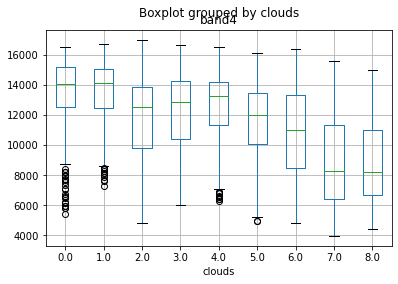

In [38]:
band4_samples.boxplot('band4', by='clouds')

Try looking at band 6:

In [39]:
sample_fnames[6] = {}
for idx, quarter in sample_quarters.iterrows():
    year, month, day, quarter = idx
    iso_date = f'{year}-{month:02d}-{day:02d}'
    key = f"{iso_date}_{quarter}"
    try:
        sample_fnames[6][key] = get_quarter(iso_date, quarter, band=6)
    except pd.errors.EmptyDataError:
        continue

Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading
Downloading


In [40]:
satellite_rows = []
for idx, quarter in sample_quarters.reset_index().iterrows():
    dirname = f"data/satellite_{quarter.year}-{quarter.month:02d}-{quarter.sday:02d}_q{quarter.quarter}"

    for fname in glob.glob(f'{dirname}/GOES13_6_*.nc'):
        try:
            data = scipy.io.netcdf_file(fname, 'r', mmap=False)
            print(f"Read {fname}")
        except:
            print(f"could not read {fname}")
            continue
        window_size = 3
        min_pix = 128-window_size
        max_pix = 128+window_size + 1
        values = data.variables['data'].data[0,min_pix:max_pix,min_pix:max_pix]
        for value in values.flatten():
            satellite_rows.append(pd.Series({'year': quarter.year,
                                             'month': quarter.month,
                                             'sday': quarter.sday,
                                             'quarter': quarter.quarter,
                                             'clouds': quarter.clouds,
                                             'band6': value}
                                           )
                                 )
band6_samples = pd.DataFrame(satellite_rows).set_index(['year', 'month', 'sday', 'quarter'])

Read data/satellite_2011-01-24_q1/GOES13_6_2011-01-25T022004.nc
Read data/satellite_2011-01-24_q1/GOES13_6_2011-01-25T015056.nc
Read data/satellite_2011-01-24_q1/GOES13_6_2011-01-25T011734.nc
Read data/satellite_2011-01-24_q1/GOES13_6_2011-01-25T024912.nc
Read data/satellite_2011-03-01_q4/GOES13_6_2011-03-02T075038.nc
Read data/satellite_2011-03-01_q4/GOES13_6_2011-03-02T081959.nc
Read data/satellite_2011-03-13_q3/GOES13_6_2011-03-14T051947.nc
Read data/satellite_2011-03-13_q3/GOES13_6_2011-03-14T072050.nc
Read data/satellite_2011-03-13_q3/GOES13_6_2011-03-14T064726.nc
Read data/satellite_2011-03-15_q3/GOES13_6_2011-03-16T071804.nc
Read data/satellite_2011-03-15_q3/GOES13_6_2011-03-16T064844.nc
Read data/satellite_2011-03-15_q3/GOES13_6_2011-03-16T052108.nc
could not read data/satellite_2011-04-20_q2/GOES13_6_2011-04-26T171636.nc
Read data/satellite_2011-06-30_q1/GOES13_6_2011-06-30T235055.nc
Read data/satellite_2011-06-30_q1/GOES13_6_2011-07-01T014919.nc
Read data/satellite_2011-06-30

In [41]:
band6_samples

clouds    band6
year   month sday quarter                 
2011.0 1.0   24.0 1.0         2.0  17632.0
                  1.0         2.0  17664.0
                  1.0         2.0  17728.0
                  1.0         2.0  17664.0
                  1.0         2.0  17248.0
...                           ...      ...
2016.0 12.0  21.0 2.0         5.0  16960.0
                  2.0         5.0  16448.0
                  2.0         5.0  15200.0
                  2.0         5.0  15392.0
                  2.0         5.0  15200.0

[15190 rows x 2 columns]

<AxesSubplot:title={'center':'band4'}, xlabel='clouds'>

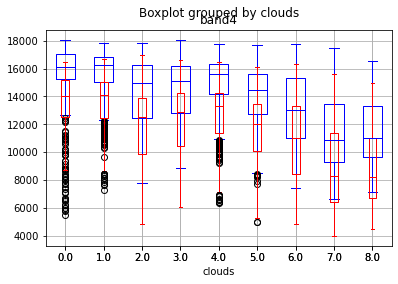

In [42]:
fig, ax = plt.subplots(1)
band6_samples.boxplot('band6', by='clouds', color='blue', ax=ax)
band4_samples.boxplot('band4', by='clouds', color='red', widths=0.2, ax=ax)

In [43]:
band6_sample_stats = band6_samples.groupby(['year', 'month', 'sday', 'quarter', 'clouds']).describe().droplevel(0, axis=1).reset_index(level='clouds')
band4_sample_stats = band4_samples.groupby(['year', 'month', 'sday', 'quarter', 'clouds']).describe().droplevel(0, axis=1).reset_index(level='clouds')

band6_sample_stats['range'] = band6_sample_stats['max'] - band6_sample_stats['min']
band4_sample_stats['range'] = band4_sample_stats['max'] - band4_sample_stats['min']
band6_sample_stats

clouds  count          mean          std      min  \
year   month sday quarter                                                      
2011.0 1.0   24.0 1.0         2.0  196.0  17073.632653   716.768094  15040.0   
       3.0   1.0  4.0         1.0   98.0  15852.734694  1090.643143  13184.0   
             13.0 3.0         0.0  147.0  16151.510204   923.297117  14432.0   
             15.0 3.0         3.0  147.0  14641.197279  1807.701358  10976.0   
       6.0   30.0 1.0         3.0  245.0  13749.028571  2090.205681   9088.0   
...                           ...    ...           ...          ...      ...   
2016.0 10.0  19.0 3.0         4.0  196.0  14492.897959  1699.479984  10240.0   
                  4.0         4.0   49.0  14539.102041  1624.946207  10752.0   
             23.0 3.0         8.0  196.0  10272.163265  1180.179549   8736.0   
       11.0  16.0 3.0         0.0  147.0  16044.190476  1177.026980  13888.0   
       12.0  21.0 2.0         5.0  147.0  16489.578231   988.340860  13568.0   

                               25%      50%      75%      max   range  
year   month sday quarter                                              
2011.0 1.0   24.0 1.0      16504.0  17440.0  17664.0  17856.0  2816.0  
       3.0   1.0  4.0      14984.0  16224.0  16816.0  17120.0  3936.0  
             13.0 3.0      15200.0  16640.0  16896.0  17248.0  2816.0  
             15.0 3.0      13104.0  15136.0  16160.0  16736.0  5760.0  
       6.0   30.0 1.0      11936.0  14592.0  15552.0  16256.0  7168.0  
...                            ...      ...      ...      ...     ...  
2016.0 10.0  19.0 3.0      13128.0  15456.0  15816.0  16416.0  6176.0  
                  4.0      13696.0  15392.0  15712.0  16320.0  5568.0  
             23.0 3.0       9600.0   9984.0  10624.0  15712.0  6976.0  
       11.0  16.0 3.0      14816.0  16800.0  16992.0  17184.0  3296.0  
       12.0  21.0 2.0      15648.0  16864.0  17312.0  17664.0  4096.0  

[83 rows x 10 columns]

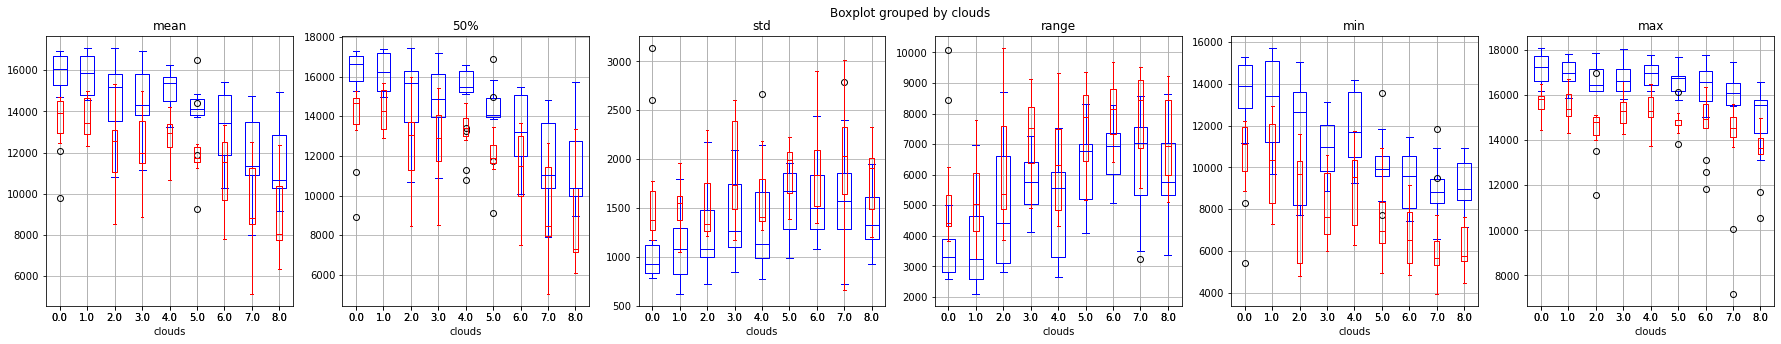

In [44]:
stat_names = ('mean', '50%', 'std', 'range', 'min', 'max')
fig, axes = plt.subplots(1, len(stat_names), figsize=(len(stat_names)*5, 5))
for ax, stat_name in zip(axes, stat_names):
    band6_sample_stats.boxplot(stat_name, by='clouds', color='blue', ax=ax)
    band4_sample_stats.boxplot(stat_name, by='clouds', color='red', widths=0.2, ax=ax)

## Infer missing data in late 2015

In [45]:
inferred_values = pd.DataFrame({'clouds': np.nan}, index=qs_to_get.index)
inferred_values.head()

clouds
year month sday quarter        
2015 7     1    1           NaN
                2           NaN
                3           NaN
                4           NaN
           3    2           NaN

In [46]:
satellite_rows = []
for idx, quarter in qs_to_get.reset_index().iterrows():
    dirname = f"data/satellite_{quarter.year}-{quarter.month:02d}-{quarter.sday:02d}_q{quarter.quarter}"

    for fname in glob.glob(f'{dirname}/GOES13_6_*.nc'):
        try:
            data = scipy.io.netcdf_file(fname, 'r', mmap=False)
            print(f"Read {fname}")
        except:
            print(f"could not read {fname}")
            continue
        window_size = 3
        min_pix = 128-window_size
        max_pix = 128+window_size + 1
        values = data.variables['data'].data[0,min_pix:max_pix,min_pix:max_pix]
        for value in values.flatten():
            satellite_rows.append(pd.Series({'year': quarter.year,
                                             'month': quarter.month,
                                             'sday': quarter.sday,
                                             'quarter': quarter.quarter,
                                             'band6': value}
                                           )
                                 )
inferred_clouds = pd.DataFrame(satellite_rows).set_index(['year', 'month', 'sday', 'quarter']).groupby(['year', 'month', 'sday', 'quarter']).describe().droplevel(0, axis=1)
inferred_clouds['clouds'] = 1
inferred_clouds.loc[inferred_clouds['mean']>16000, 'clouds'] = 0
inferred_clouds.loc[inferred_clouds['50%']<15000, 'clouds'] = 8
inferred_clouds

Read data/satellite_2015-07-01_q1/GOES13_6_2015-07-01T231648.nc
Read data/satellite_2015-07-01_q1/GOES13_6_2015-07-02T011652.nc
Read data/satellite_2015-07-01_q1/GOES13_6_2015-07-01T234614.nc
Read data/satellite_2015-07-01_q1/GOES13_6_2015-07-02T014646.nc
Read data/satellite_2015-07-01_q1/GOES13_6_2015-07-02T004645.nc
Read data/satellite_2015-07-01_q2/GOES13_6_2015-07-02T034701.nc
Read data/satellite_2015-07-01_q2/GOES13_6_2015-07-02T021701.nc
Read data/satellite_2015-07-01_q2/GOES13_6_2015-07-02T044701.nc
Read data/satellite_2015-07-01_q2/GOES13_6_2015-07-02T041637.nc
Read data/satellite_2015-07-01_q2/GOES13_6_2015-07-02T024621.nc
Read data/satellite_2015-07-01_q3/GOES13_6_2015-07-02T071645.nc
Read data/satellite_2015-07-01_q3/GOES13_6_2015-07-02T054613.nc
Read data/satellite_2015-07-01_q3/GOES13_6_2015-07-02T051530.nc
Read data/satellite_2015-07-01_q3/GOES13_6_2015-07-02T064650.nc
Read data/satellite_2015-07-01_q3/GOES13_6_2015-07-02T074639.nc
Read data/satellite_2015-07-01_q4/GOES13

count          mean          std      min      25%  \
year   month sday quarter                                                       
2015.0 7.0   1.0  1.0      245.0  15137.306122   986.330902  13184.0  14240.0   
                  2.0      245.0  14835.722449   999.682435  12896.0  13888.0   
                  3.0      245.0  14529.044898   993.571972  12608.0  13600.0   
                  4.0      196.0  14359.836735  1000.025094  12192.0  13432.0   
             3.0  2.0      196.0  15008.979592  1364.065725  10688.0  13944.0   
                  3.0      245.0  14575.281633  1156.492382  12128.0  13632.0   
                  4.0      196.0  13519.673469  1236.743937   9984.0  12672.0   
             4.0  1.0      245.0  13422.106122  1400.091638  10464.0  12448.0   
                  2.0      245.0  10936.685714  1336.301448   8160.0   9920.0   
                  3.0      245.0  11126.334694  1391.108286   8224.0  10016.0   
             25.0 3.0      245.0  13817.338776  1727.747867  10432.0  12320.0   
       8.0   3.0  1.0       49.0  13462.857143  2130.544844   9216.0  12000.0   
                  2.0      245.0  10750.302041  2432.374700   7072.0   8768.0   
                  3.0      196.0   8790.530612   705.493378   6752.0   8376.0   
                  4.0      245.0   9000.620408   773.451201   6880.0   8480.0   
             8.0  1.0      196.0  11388.571429  1113.538578   9888.0  10560.0   
                  2.0      245.0  11900.995918  1404.497642   9600.0  10720.0   
                  3.0      196.0  12303.836735  1167.933109  10304.0  11360.0   
                  4.0      245.0  12748.538776  1103.546371  10144.0  11904.0   
             10.0 1.0      196.0   9208.816327  1538.408577   7136.0   8160.0   
                  2.0      245.0  10144.391837  1956.302663   7808.0   8608.0   
                  3.0      196.0  10378.448980  1767.012754   7968.0   8920.0   
                  4.0      245.0  10768.065306  1731.005582   8000.0   9312.0   
             11.0 1.0      196.0  10641.632653   741.067911   9312.0  10080.0   
                  2.0      245.0  11343.412245  1513.065344   8960.0  10176.0   
                  3.0      196.0  11234.612245  1669.436003   8384.0   9784.0   
                  4.0      245.0  11459.787755  1832.149259   8512.0   9728.0   
             12.0 1.0      196.0  13496.163265  1173.766435  11040.0  12352.0   
                  2.0      245.0  13304.816327  1459.701514  10240.0  11840.0   
                  3.0      196.0  13212.244898  1490.090488  10272.0  11792.0   
                  4.0      245.0  13303.379592  1493.078196  10336.0  11840.0   
             16.0 1.0      196.0  14005.061224  1099.809446  11680.0  12840.0   
             25.0 1.0      196.0  14855.346939  1281.842097  12384.0  13792.0   
                  2.0      245.0  14520.685714  1525.061048   9312.0  13248.0   
                  3.0      196.0  14333.387755  1543.939640   9568.0  13136.0   
                  4.0      196.0  14278.040816  1450.987624  10784.0  12984.0   
             26.0 1.0      196.0  14858.122449  1662.639898   9856.0  13344.0   
                  2.0      245.0  15016.620408  1515.248096  11616.0  13376.0   
                  3.0      196.0  14979.918367  1368.146578  12448.0  13800.0   
                  4.0      196.0  14400.000000  1478.712898  11232.0  12880.0   
             27.0 2.0      147.0  10420.244898  1716.340498   7616.0   8960.0   
                  3.0      196.0  12248.979592  2882.336207   7200.0   9816.0   
       11.0  5.0  4.0      245.0  15170.742857  1172.339927  12896.0  14176.0   
             11.0 2.0       98.0  15257.142857   965.004140  13312.0  14536.0   
                  3.0      147.0  15079.619048   973.763138  13088.0  14432.0   
                  4.0      196.0  14967.673469   958.871760  13024.0  14296.0   

                               50%      75%      max  clouds  
year   month sday quarter                                     
2015.0 7.0  

In [47]:
inferred_cloudy = inferred_clouds.query('clouds==8').reset_index().drop(columns=['count', 'clouds'])
for col in ('year', 'month', 'sday', 'quarter'):
    inferred_cloudy[col] = inferred_cloudy[col].astype(int)

In [48]:
inferred_cloudy.to_csv('satellite_cloudy.txt', index=False, sep="\t")

In [49]:
!cat satellite_cloudy.txt

year	month	sday	quarter	mean	std	min	25%	50%	75%	max
2015	7	1	4	14359.836734693878	1000.0250939813261	12192.0	13432.0	14944.0	15200.0	15488.0
2015	7	3	3	14575.281632653061	1156.4923818920608	12128.0	13632.0	14848.0	15616.0	16064.0
2015	7	3	4	13519.673469387755	1236.7439365632042	9984.0	12672.0	13568.0	14528.0	16032.0
2015	7	4	1	13422.10612244898	1400.0916381613192	10464.0	12448.0	13600.0	14528.0	16096.0
2015	7	4	2	10936.685714285713	1336.3014482727083	8160.0	9920.0	10848.0	11840.0	14688.0
2015	7	4	3	11126.33469387755	1391.1082864285186	8224.0	10016.0	10944.0	12192.0	14368.0
2015	7	25	3	13817.338775510205	1727.7478670621588	10432.0	12320.0	13952.0	15488.0	16608.0
2015	8	3	1	13462.857142857143	2130.544844243682	9216.0	12000.0	13280.0	15488.0	16608.0
2015	8	3	2	10750.302040816327	2432.374699524985	7072.0	8768.0	10016.0	12640.0	16640.0
2015	8	3	3	8790.530612244898	705.4933782470196	6752.0	8376.0	8768.0	9160.0	11648.0
2015	8	3	4	9000.620408163266	773.4512014711784	6880.0	8480.0	8960.0	9504.